# Stanford dogs: breed classifier

Stanford Dogs Dataset has over 20k images categorized into 120 breeds with uniform bounding boxes. The number of photos for each breed is relatively low, which is usually a good reason to employ transfer learning; but this is a model trained from scratch using a CNN based on AlexNet for only 12 breeds.

A much simpler two layers CNN also produces similar results. 

Some more possible tweaking for Alexnet layers is to adjust dropout to prevent overfitting

## 1. Import libraries and define data folders

In [1]:
# files loading
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
# image pretreatment
import matplotlib.pyplot as plt

import cv2
import numpy as np
from PIL import Image
from keras.utils.vis_utils import plot_model

In [3]:
import keras
from numpy import expand_dims
from keras import backend as K
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator


In [4]:
import imageio
import imgaug as ia
from imgaug import augmenters as iaa

In [5]:
# libraries for a CNN
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout, Activation
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

from tensorflow.python.client import device_lib


In [6]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [7]:
ANNOTATION_DIR = '../input/stanford-dogs-dataset/annotations/Annotation' 
IMAGES_DIR = '../input/stanford-dogs-dataset/images/Images'

### 1.1 Visualize list of breeds (classes) and a sample data (image)

In [8]:
breed_list = os.listdir(IMAGES_DIR)
print("num. breeds total:", len(breed_list))

num. breeds total: 120


In [9]:
filtered_breeds = [breed.split('-',1)[1] for breed in breed_list] #visualize breeds
filtered_breeds[:12]

['Lakeland_terrier',
 'wire-haired_fox_terrier',
 'papillon',
 'Irish_setter',
 'silky_terrier',
 'black-and-tan_coonhound',
 'whippet',
 'Border_terrier',
 'affenpinscher',
 'Weimaraner',
 'standard_poodle',
 'Newfoundland']

## 1.2 Example equalization 

n02111277-Newfoundland


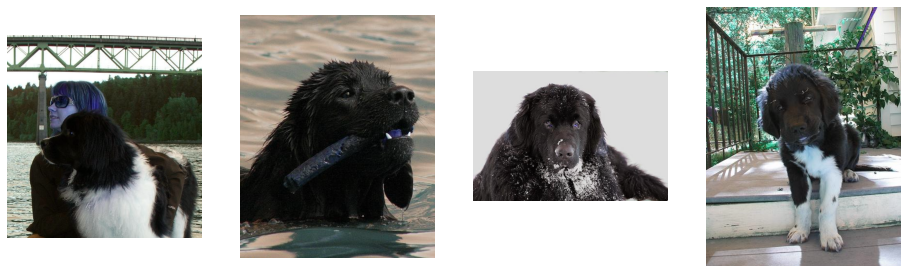

In [10]:
def show_dir_images(breed, n_to_show):
    plt.figure(figsize=(16,16))
    img_dir = "../input/stanford-dogs-dataset/images/Images/{}/".format(breed)
    images = os.listdir(img_dir)[:n_to_show]
    for i in range(n_to_show):
        img = cv2.imread(img_dir + images[i])
        plt.subplot(n_to_show/4+1, 4, i+1)
        plt.imshow(img)
        plt.axis('off')



print(breed_list[11])
show_dir_images(breed_list[11], 4)

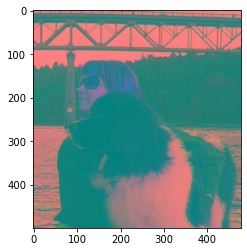

In [11]:
img_dir = "../input/stanford-dogs-dataset/images/Images/{}/".format(breed_list[11])
images = os.listdir(img_dir)[:12]
images = os.listdir(img_dir)[:4]
img = cv2.imread(img_dir + images[0])

# transform image for equalization
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
img_grayscale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img_to_yuv = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)

plt.imshow(img_to_yuv)

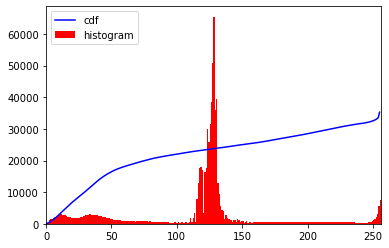

In [12]:
hist,bins = np.histogram(img.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(img_to_yuv.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

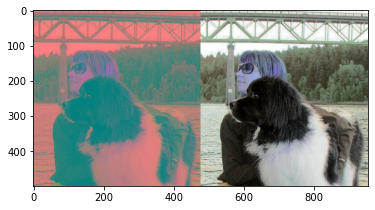

In [13]:
img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0])
equ = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2BGR)
res = np.hstack((img_to_yuv,equ)) #stacking images side-by-side
cv2.imwrite('res.png',res)
plt.imshow(res)

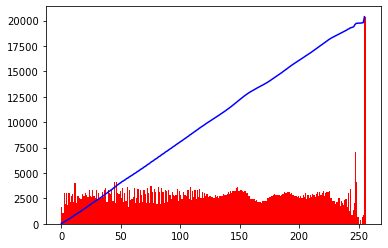

In [14]:
hist,bins = np.histogram(equ.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(equ.flatten(),256,[0,256], color = 'r')
plt.show()

## 1.3 Example augmentations: mirroring and rotation

Augmented by rotation:


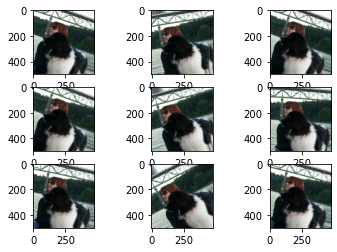

<Figure size 1080x1080 with 0 Axes>

In [15]:
print("Augmented by rotation:")
#ia.imshow(image_aug_2)
# convert to numpy array
data = img_to_array(img_RGB)

# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range=30)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.figure(figsize = (15,15))
plt.show()

## 2. Prepare data for training the CNN model


### 2.1 data loading and image equalization

In [16]:
num_breeds = 10 # integer between 2 and 120
breeds = breed_list[:num_breeds]

def load_images_and_labels(breeds):
    img_lst=[]
    labels=[]
    
    for index, breed in enumerate(breeds):
        for image_name in os.listdir(IMAGES_DIR+"/"+breed):
            img = cv2.imread(IMAGES_DIR+"/"+breed+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0]) # convert to yuv color space for equalization
            equ = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2RGB) # equalize
            
            img_array = Image.fromarray(img, 'RGB')
            
            #resize image to 227 x 227 because the input image resolution for AlexNet is 227 x 227
            resized_img = img_array.resize((227, 227))
            
            img_lst.append(np.array(resized_img))
            
            labels.append(filtered_breeds[index])
            
    return img_lst, labels 

images, labels = load_images_and_labels(breeds)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))

No. of images loaded =  1716 
No. of labels loaded =  1716


### 2.2 label encoding and features normalization

In [17]:
# replace numbers with names
le = LabelEncoder()
nlabels = le.fit_transform(labels) # encode labels as number values. This prepares for categorical encoding
Y=to_categorical(nlabels,num_classes = num_breeds) # category encoding

In [18]:
#Normalization for the images
images = np.array(images)
images = images.astype(np.float32)
#labels = labels.astype(np.int32)
X_norm = images/255

### 2.3 test and train sets 

In [19]:
x_train, x_test, y_train, y_test = train_test_split(X_norm, Y, test_size = 0.2, random_state = 42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)

print("\nx_val shape = ",x_val.shape)
print("y_val shape = ",y_val.shape)

print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (1234, 227, 227, 3)
y_train shape =  (1234, 10)

x_val shape =  (138, 227, 227, 3)
y_val shape =  (138, 10)

x_test shape =  (344, 227, 227, 3)
y_test shape =  (344, 10)


### 2.4 augment the training data.

In [20]:
# example of training images
df_y_train = pd.DataFrame(y_train, columns = filtered_breeds[:num_breeds]) 
df_given_train = df_y_train.apply(lambda s, n: pd.Series(s.nlargest(n).index), axis=1, n=1)


/opt/conda/lib/python3.7/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


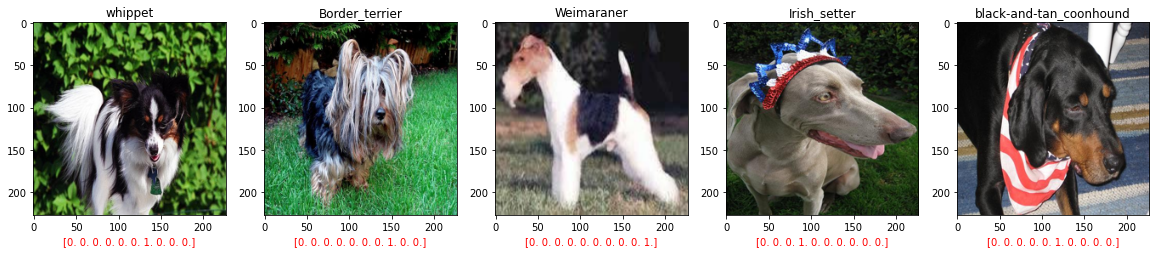

In [21]:
plt.figure(figsize = (20,20))
for i in range(5):
    img = x_train[i]
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    #plt.axis("off")
    plt.xlabel(y_train[i], color = "r")
    plt.title(df_given_train.iloc[i,0])
plt.show()

In [22]:
aug = ImageDataGenerator(rotation_range=30, #rotations (as seen above)
                        width_shift_range=0.2,  # randomly shift images horizontally 
                        height_shift_range=0.2,# randomly shift images vertically 
                        shear_range=0.2, # shear image
                        zoom_range=0.2, # zoom into image 
                        horizontal_flip=True, # randomly flip images horizontally
                        fill_mode='reflect') #  creates a ‘reflection’ and fills the empty values in reverse order of the known values
# fit parameters from data
aug.fit(x_train, augment=True)

## 3. First CNN model (2 convolutional layers only)

### 3.1 define layers

In [23]:
input_shape = (None, 227, 227, 3)
 

model1 = tf.keras.Sequential() 
model1.add(tf.keras.layers.Conv2D(16, (3, 3), use_bias=False))
model1.add(tf.keras.layers.MaxPool2D(pool_size=(4, 4), strides=(4, 4), padding='same'))        
model1.add(tf.keras.layers.Flatten())        
model1.add( tf.keras.layers.Dense(512, activation='relu'))       
model1.add(tf.keras.layers.Dense(num_breeds, activation='softmax'))        

model1.build(input_shape)
model1.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  432       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  26616320  
_________________________________________________________________
dense_1 (Dense)              multiple                  5130      
Total params: 26,621,882
Trainable params: 26,621,882
Non-trainable params: 0
_________________________________________________________________


### 3.2 Compile the CNN model

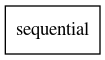

In [24]:
model1.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False), metrics=['accuracy']) #compile model

plot_model(model1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### 3.3 Fit the model using training data

In [25]:
%%time
history_1 = model1.fit(aug.flow(x_train, y_train), 
          validation_data=(x_val, y_val),
          epochs=5)

Epoch 1/5
39/39 [==============================] - 13s 336ms/step - loss: 5.7880 - accuracy: 0.1402 - val_loss: 2.1860 - val_accuracy: 0.2174
Epoch 2/5
39/39 [==============================] - 14s 351ms/step - loss: 2.2405 - accuracy: 0.1791 - val_loss: 2.1428 - val_accuracy: 0.2174
Epoch 3/5
39/39 [==============================] - 13s 329ms/step - loss: 2.1155 - accuracy: 0.2310 - val_loss: 1.9864 - val_accuracy: 0.2536
Epoch 4/5
39/39 [==============================] - 13s 331ms/step - loss: 2.0605 - accuracy: 0.2650 - val_loss: 1.9304 - val_accuracy: 0.2681
Epoch 5/5
39/39 [==============================] - 13s 344ms/step - loss: 2.0680 - accuracy: 0.2642 - val_loss: 1.9361 - val_accuracy: 0.3261
CPU times: user 1min 9s, sys: 2.75 s, total: 1min 12s
Wall time: 1min 12s


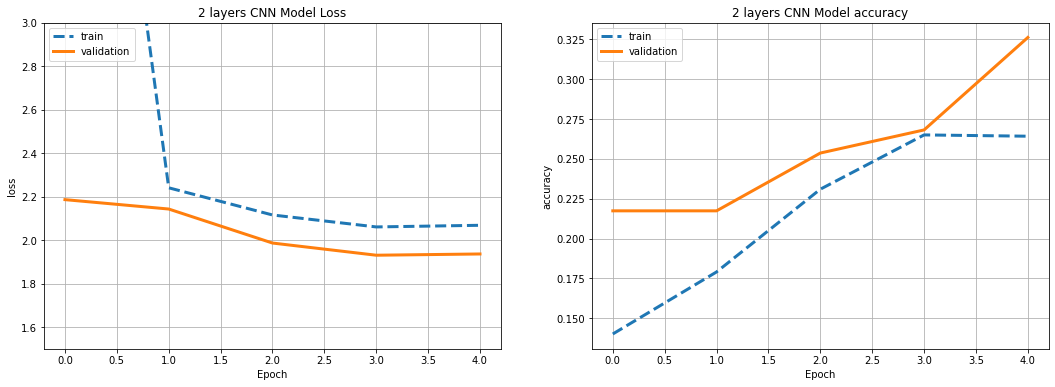

In [26]:
plt.figure(figsize=(18, 6))

plt.subplot(121)
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
plt.plot(loss,"--", linewidth=3 , label="train")
plt.plot(val_loss, linewidth=3 , label="valid")

plt.legend(['train','validation'], loc='upper left')
plt.grid()
plt.ylabel('loss')
plt.ylim((1.5, 3))
plt.xlabel('Epoch')
plt.title('2 layers CNN Model Loss')
plt.legend(['train','validation'], loc='upper left')

plt.subplot(122)
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

plt.plot(acc,"--", linewidth=3 , label="train")
plt.plot(val_acc, linewidth=3 , label="valid")

plt.legend(['train','validation'], loc='upper left')
plt.grid()

plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.title('2 layers CNN Model accuracy')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [27]:
test_loss, test_accuracy = model1.evaluate(x_test, y_test)

print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)

11/11 [==============================] - 0s 12ms/step - loss: 1.9651 - accuracy: 0.3023
Test results 
 Loss: 1.9650602340698242 
 Accuracy 0.302325576543808


## 4. AlexNet

![Alexnet](https://engmrk.com/wp-content/uploads/2018/10/AlexNet_Original_Image.jpg)

### 4.1 define layers

In [28]:
# Initialize the classifier.
classifier = Sequential()
          
# 1st Convolutional Layer
classifier.add(Conv2D(filters = 96, input_shape = (227,227,3), kernel_size = (11,11), strides = (4,4), padding = 'valid'))
classifier.add(Activation('relu'))
# Batch Normalisation before passing it to the next layer
classifier.add(BatchNormalization())
# Pooling Layer
classifier.add(MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = 'valid'))

# 2nd Convolutional Layer
classifier.add(Conv2D(filters = 256, kernel_size = (5,5), strides = (1,1), padding = 'same'))
classifier.add(Activation('relu'))
# Batch Normalisation
classifier.add(BatchNormalization())
# Pooling Layer
classifier.add(MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = 'valid'))

# 3rd Convolutional Layer
classifier.add(Conv2D(filters = 384, kernel_size = (3,3), strides = (1,1), padding = 'same'))
classifier.add(Activation('relu'))
# Batch Normalisation
classifier.add(BatchNormalization())
# Dropout
classifier.add(Dropout(0.5))

# 4th Convolutional Layer
classifier.add(Conv2D(filters = 384, kernel_size = (3,3), strides = (1,1), padding = 'same'))
classifier.add(Activation('relu'))
# Batch Normalisation
classifier.add(BatchNormalization())
# Dropout
classifier.add(Dropout(0.5))

# 5th Convolutional Layer
classifier.add(Conv2D(filters = 256, kernel_size = (3,3), strides = (1,1), padding = 'same'))
classifier.add(Activation('relu'))
# Batch Normalisation
classifier.add(BatchNormalization())
# Pooling Layer
classifier.add(MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = 'valid'))
# Dropout
classifier.add(Dropout(0.5))

# Passing it to a dense layer
classifier.add(Flatten())

# 1st Dense Layer
classifier.add(Dense(4096, input_shape = (227,227,3)))
classifier.add(Activation('relu'))
# Add Dropout to prevent overfitting
classifier.add(Dropout(0.5))
# Batch Normalisation
classifier.add(BatchNormalization())

# 2nd Dense Layer
classifier.add(Dense(4096))
classifier.add(Activation('relu'))
# Add Dropout
classifier.add(Dropout(0.3))
# Batch Normalisation
classifier.add(BatchNormalization())

# 3rd Dense Layer
classifier.add(Dense(1000))
classifier.add(Activation('relu'))
# Add Dropout
classifier.add(Dropout(0.2))
# Batch Normalisation
classifier.add(BatchNormalization())

# Output Layer
classifier.add(Dense(num_breeds))
classifier.add(Activation('softmax'))

# Get the classifier summary.
classifier.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
activation (Activation)      (None, 55, 55, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
activation_1 (Activation)    (None, 27, 27, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 256)      

In [29]:
classifier.build(input_shape)

### 4.2 compile and run

In [30]:
#classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Compile 
INIT_LR = 1e-3
DECAY = 1e-7

opt = tf.keras.optimizers.Adam(lr = INIT_LR, decay = DECAY)
classifier.compile(loss="categorical_crossentropy", optimizer = opt,metrics = ["accuracy"])
print("[INFO] Training network...")

#¤K.set_value(classifier.optimizer.learning_rate, 0.00001)

[INFO] Training network...


In [31]:
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [32]:
%%time
history_2 = classifier.fit( aug.flow(x_train, y_train,  shuffle = False),
    validation_data = (x_val, y_val),
    epochs = 40,
    verbose=1)

#hist = model.fit(datagen.flow(x_train, y_train), epochs=25)

Epoch 1/40
39/39 [==============================] - 14s 362ms/step - loss: 3.9505 - accuracy: 0.1394 - val_loss: 350.9556 - val_accuracy: 0.0725
Epoch 2/40
39/39 [==============================] - 14s 348ms/step - loss: 2.8178 - accuracy: 0.1564 - val_loss: 33.8179 - val_accuracy: 0.0942
Epoch 3/40
39/39 [==============================] - 13s 335ms/step - loss: 2.4548 - accuracy: 0.1564 - val_loss: 4.8257 - val_accuracy: 0.2246
Epoch 4/40
39/39 [==============================] - 13s 341ms/step - loss: 2.4261 - accuracy: 0.1937 - val_loss: 3.9083 - val_accuracy: 0.1812
Epoch 5/40
39/39 [==============================] - 14s 353ms/step - loss: 2.3523 - accuracy: 0.1904 - val_loss: 2.7650 - val_accuracy: 0.1884
Epoch 6/40
39/39 [==============================] - 14s 365ms/step - loss: 2.3424 - accuracy: 0.1904 - val_loss: 3.0427 - val_accuracy: 0.1739
Epoch 7/40
39/39 [==============================] - 13s 329ms/step - loss: 2.3241 - accuracy: 0.2010 - val_loss: 2.8109 - val_accuracy: 0.2

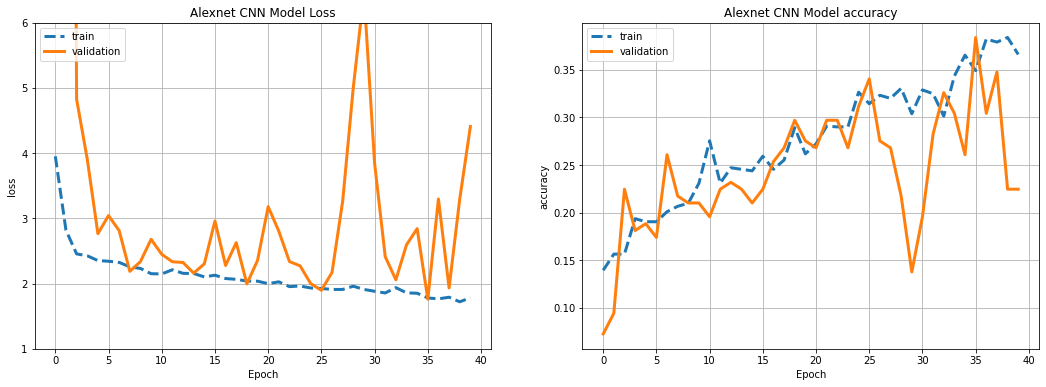

In [33]:
## plot the history of loss and accuracy for train and valid data for the Alexnet model
plt.figure(figsize=(18, 6))

plt.subplot(121)
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
plt.plot(loss,"--", linewidth=3 , label="train")
plt.plot(val_loss, linewidth=3 , label="valid")

plt.legend(['train','validation'], loc='upper left')
plt.grid()
plt.ylabel('loss')
plt.ylim((1, 6))
plt.xlabel('Epoch')
plt.title('Alexnet CNN Model Loss')
plt.legend(['train','validation'], loc='upper left')

plt.subplot(122)
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

plt.plot(acc,"--", linewidth=3 , label="train")
plt.plot(val_acc, linewidth=3 , label="valid")

plt.legend(['train','validation'], loc='upper left')
plt.grid()

plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.title('Alexnet CNN Model accuracy')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [34]:
test_loss, test_accuracy = classifier.evaluate(x_test, y_test)

print(test_loss,test_accuracy)

11/11 [==============================] - 0s 24ms/step - loss: 4.0649 - accuracy: 0.1686
4.06493616104126 0.16860465705394745


In [35]:
pred = classifier.predict(x_test)
print(y_test.shape)
print(pred.shape)

(344, 10)
(344, 10)


In [36]:
roundpred = np.around(pred, decimals=1)
df_pred = pd.DataFrame(roundpred, columns = filtered_breeds[:num_breeds])
df_pred.head()

,Lakeland_terrier,wire-haired_fox_terrier,papillon,Irish_setter,silky_terrier,black-and-tan_coonhound,whippet,Border_terrier,affenpinscher,Weimaraner
0,0.1,0.5,0.1,0.1,0.0,0.2,0.0,0.1,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.8,0.1
2,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.7,0.0
3,0.0,0.0,0.0,0.0,0.0,0.7,0.0,0.0,0.3,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7,0.2


In [37]:
df_breed_pred = df_pred.apply(lambda s, n: pd.Series(s.nlargest(n).index), axis=1, n=3)
df_breed_pred.columns = ['1st_prob_breed','2nd_prob_breed','3rd_prob_breed']
df_breed_pred.head()

,1st_prob_breed,2nd_prob_breed,3rd_prob_breed
0,wire-haired_fox_terrier,black-and-tan_coonhound,Lakeland_terrier
1,affenpinscher,whippet,Weimaraner
2,affenpinscher,black-and-tan_coonhound,Lakeland_terrier
3,black-and-tan_coonhound,affenpinscher,Lakeland_terrier
4,affenpinscher,Weimaraner,Lakeland_terrier


In [38]:
prob_df = df_pred.apply(np.sort, axis=1).apply(lambda df_pred: df_pred[-3:]).apply(pd.Series)
prob_df.columns = ['3rd_prob','2nd_prob','1st_prob']
prob_df = prob_df*100
prob_df = prob_df.astype(int)
prob_df = pd.concat([prob_df, df_breed_pred], axis=1)

In [39]:
prob_df['final']= prob_df["1st_prob_breed"].astype(str) +" "+ prob_df["1st_prob"].astype(str)+"%, "+prob_df["2nd_prob_breed"].astype(str) +" "+ prob_df["2nd_prob"].astype(str)+"%, "+prob_df["3rd_prob_breed"].astype(str) +" "+ prob_df["3rd_prob"].astype(str)+"%"

In [40]:
df_test = pd.DataFrame(y_test, columns = filtered_breeds[:num_breeds])
given_df = df_test.apply(lambda s, n: pd.Series(s.nlargest(n).index), axis=1, n=1)
given_df.head()


,0
0,wire-haired_fox_terrier
1,Lakeland_terrier
2,papillon
3,papillon
4,Weimaraner


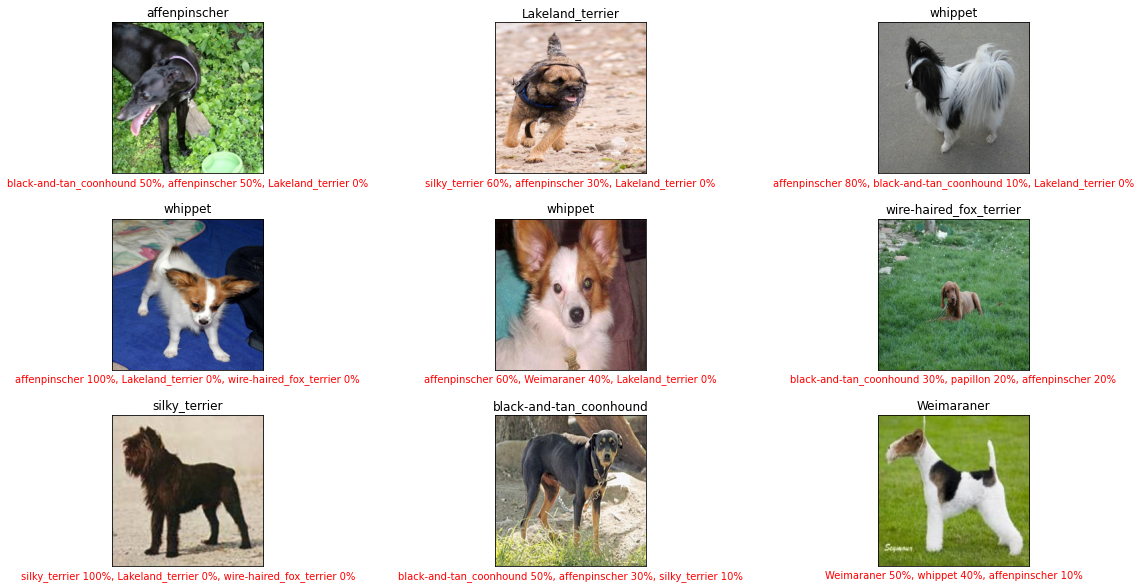

In [41]:
plt.figure(1 , figsize = (19 , 10))
n = 0 
r = np.random.randint(low=1, high=100, size=9)
for i in r:
    n += 1 
    
    
    plt.subplot(3, 3, n)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    plt.imshow(x_test[i])
    plt.title(given_df.iloc[i,0])
 
    plt.xlabel(prob_df.iloc[i,6], wrap=True, color = "r")
    plt.xticks([]) , plt.yticks([])

plt.show()